### Final project
# Pore space estimation and minerals determination 

#### made by Elizaveta Gladchenko and Ramilya Sharifullina

___

https://www.youtube.com/watch?v=0hkUhWIVV6M&feature=youtu.be

import the libraries

In [1]:
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm


%matplotlib inline

from skimage import io
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line, probabilistic_hough_line, rescale, ProjectiveTransform, warp, AffineTransform
from skimage.measure import LineModelND, ransac, label
from skimage.transform import ProjectiveTransform, warp, AffineTransform, rescale
from skimage.feature import canny
from skimage.morphology import dilation, disk, remove_small_objects
from skimage.metrics import adapted_rand_error, variation_of_information
from sklearn.metrics import mean_squared_error
from skimage.filters import sobel
from skimage.util import img_as_float
from skimage.segmentation import (morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  watershed,
                                  mark_boundaries)

import tensorflow as tf
from tensorflow.keras.models import load_model

from imutils import contours
from tqdm import tqdm

import joblib

from numpy import logical_and as land
from numpy import logical_not as lnot

from scipy import ndimage as ndi

___

### Why is it important?
In our project we will define the porosity of the rock samples. Porosity is one of the key parameters of reservoir rock that should be identified for calculation of the amount of oil or gas  that can be found in the field and then obtained by different production techniques. Besides, not only the value of porosity that matters. The choice of techniques also depends on porosity type and the type of minerals which form the reservoir.


### What's the expected value of your CV algorithm?
We expect to define the pore space value porosity type by using contours and segmentation techniques.

### Dataset description with image examples.
As our dataset we use the images of core microprobes. A core is a rock sample taken from a well. In images different minerals and pore space (green) are shown. Images are taken in high resolution under the microscope.

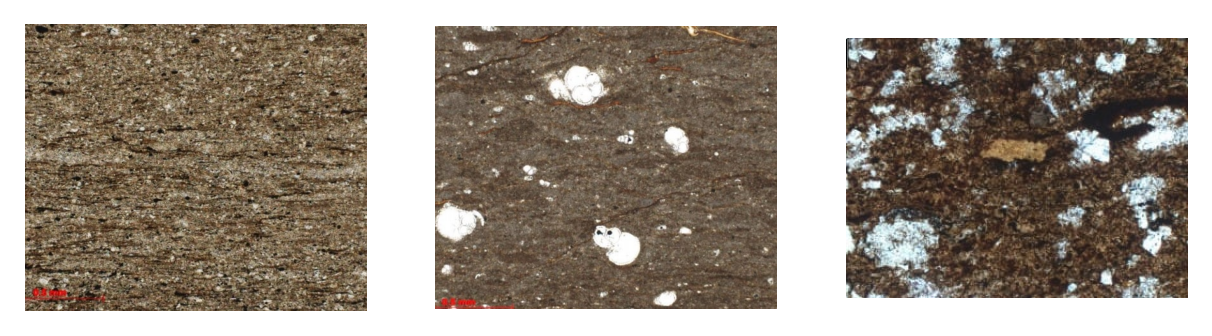

In [2]:
img1 = cv2.imread('img1.jpg')
img_rgb1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB) 
img2 = cv2.imread('img2.jpg')
img_rgb2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB) 
img3 = cv2.imread('img4.jpg')
img_rgb3 = cv2.cvtColor(img3,cv2.COLOR_BGR2RGB) 

plt.figure(dpi=250)
plt.subplot(1,3,1) 
plt.axis('off')
plt.imshow(img_rgb1)
plt.subplot(1,3,2)  
plt.axis('off')
plt.imshow(img_rgb2)
plt.subplot(1,3,3)  
plt.axis('off')
plt.imshow(img_rgb3);

___

### You can compare more than one pipeline (e.g., try 2-3 different methods within a specif step).

As for the most straight-forward solution, the image was transferred to hsv color space → then, the mask which detects pore spaces was created  → after that with a help of the function that counts black and white pixels the numbers of pixels for these colors were identified → finally, the porosity was calculated as the ratio of white pixels to the total amount of pixels that form the image.  

As for the more complicated pipeline, we decided to add contours for pore spaces. They gave us extra opportunities for image processing and deriving useful information from the sample. Thus, to the first pipeline several steps were added:
creating contours for pore spaces based on the mask from the previous pipeline→ calculating porosity by calculating area of contours for pores and diving it to the whole area of the image → approximating contours of pores and diving them into different shapes based on the amount of angles their approximation contours have → with a help of pandas and seaborn identifying which shape of pores is prevalent and what type of porosity it is.  

The last method we used was Image Segmentation with Watershed Algorithm. Before using it we preprocessed the image by using a sobel filter. After using markers, we selected areas that indicate the pore space. and in the end we used ‘watershed’ command to get beautiful image where you may see contours of porous space. 


In [3]:
d = {"porosity in each of five images":pd.Series([6.8, 2.0, 0.41, 28.7, 5.04], index=['img1.jpg', 'img2.jpg', 'img3.jpg', 'img4.jpg', 'img5.jpg'])}
df2 = pd.DataFrame(d)
print(df2)

          porosity in each of five images
img1.jpg                             6.80
img2.jpg                             2.00
img3.jpg                             0.41
img4.jpg                            28.70
img5.jpg                             5.04


In [4]:
porosity = [6.8, 2.0, 0.41, 28.7, 5.04]

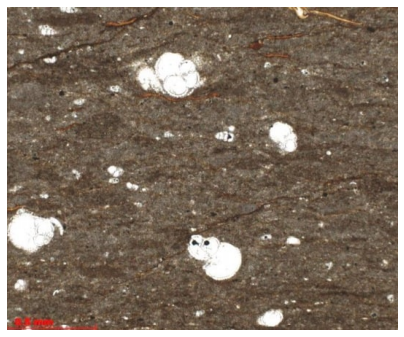

In [5]:
# upload the image

def plot_img(img, cmap='gray'):
    plt.figure(figsize=(7,7))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()
    
img = cv2.imread('img2.jpg')
title = 'img2.jpg'
orig = img.copy()
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
plot_img(orig, cmap = None)

In [6]:
def real_poros(title,porosity):
    for i in porosity:
        if title == 'img1.jpg':
            real_porosity = porosity[0]
        if title == 'img2.jpg':
            real_porosity = porosity[1]
        if title == 'img3.jpg':
            real_porosity = porosity[2]
        if title == 'img4.jpg':
            real_porosity = porosity[3]
        if title == 'img5.jpg':
            real_porosity = porosity[4]
    return (real_porosity)

In [7]:
real_porosity = real_poros(title,porosity)

In [8]:
hsv = img.copy()
hsv = cv2.cvtColor(hsv, cv2.COLOR_BGR2HSV)
hue = hsv[:, :, 0]
light = hsv[:, :, 1]
sat = hsv[:, :, 2]

# plt.figure(dpi=250)
# plt.subplot(1,3,1)         
# plt.imshow(hue, cmap='hsv')
# plt.title('hue')
# plt.axis('off')
# plt.subplot(1,3,2)
# plt.imshow(sat, cmap='gray')
# plt.title('sat')
# plt.axis('off')
# plt.subplot(1,3,3)
# plt.imshow(light, cmap='gray')
# plt.title('light')
# plt.axis('off')
# plt.show()

#### first way - mask calculation (balck and white pixels)

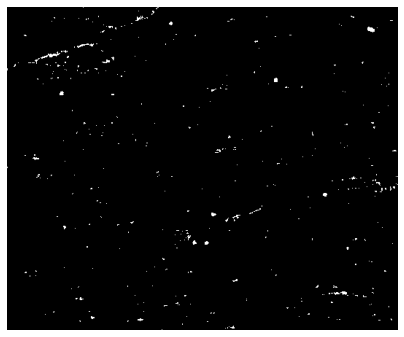

In [9]:
mask = sat < 70
plot_img(mask)
mask = mask.astype(np.uint8)

In [10]:
# function to estimate pore space
def por_by_pixels1(image):
    por_pred = []
    blackpixels = 0
    whitepixels = 0
    for col in range(0, img.shape[0]):
        for row in range(0, img.shape[1]):
            if image[col,row] == 1:
                whitepixels += 1
            else:
                blackpixels += 1
    porosity = (whitepixels/(img.shape[0]*img.shape[1]))*100
    por_pred.append(porosity)
    
    return por_pred

In [11]:
porosity_1 = por_by_pixels1(mask)

#### second way - contours calculation 

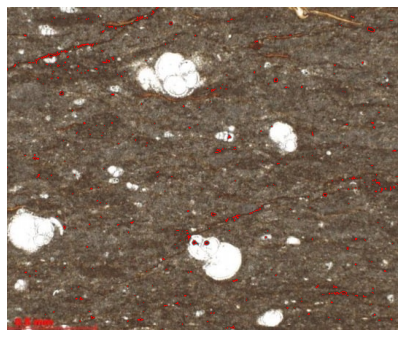

In [12]:
mask_int = mask.astype(np.uint8)
contours, hierarchy = cv2.findContours(mask_int, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img_cnt = orig.copy()
cv2.drawContours(img_cnt, contours, -1, (255,0,0), 1)
plot_img(img_cnt)

In [13]:
allporeareas = []

for contour in contours:
    area = cv2.contourArea(contour)
    allporeareas.append(area)
pore_area = np.array(allporeareas).sum()


In [14]:
def por_by_contours(image, mask):
    por_pred = []
    mask_int = mask.astype(np.uint8)
    contours, hierarchy = cv2.findContours(mask_int, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    img_cnt = image.copy()
    cv2.drawContours(img_cnt, contours, -1, (255,0,0), 4)
    
    allporeareas = []

    for contour in contours:
        area = cv2.contourArea(contour)
        allporeareas.append(area)
    
    pore_area = np.array(allporeareas).sum()
    porosity = (pore_area/(img.shape[0]*img.shape[1]))*100
    por_pred.append(porosity)
    return por_pred

In [15]:
porosity_2 = por_by_contours(orig, mask)
porosity_2

[0.2297345102927799]

In [16]:
def get_pore_shapes(contours):
    pore_shapes = []
    for cnt in contours:
        perimeter = cv2.arcLength(cnt, True)
        epsilon = 0.01 * perimeter
        approx = cv2.approxPolyDP(cnt, epsilon,True)
        if len(approx) == 3:
            shape = "triangle"
        elif len(approx) == 4:
            area = cv2.contourArea(approx)
            perimeter = cv2.arcLength(approx, True) 
            ar = area * 16 / perimeter**2
            shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
        else:
            shape = "circle"
        pore_shapes.append(shape)
    return pore_shapes

In [17]:
shape = get_pore_shapes(contours)

In [18]:
df = pd.DataFrame()
pore_shapes_series = pd.Series(shape)
df['pore_shape'] = pore_shapes_series

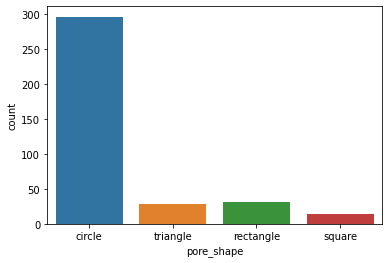

In [19]:
sns.countplot(x='pore_shape', data=df, log = False);

#### the third method - by segmentation 

In [20]:
img_seg = img.copy()
img_seg = cv2.cvtColor(img_seg, cv2.COLOR_BGR2GRAY)
img_rgb = cv2.cvtColor(img_seg, cv2.COLOR_BGR2RGB)


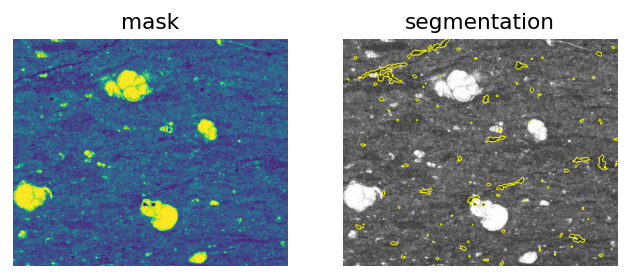

In [21]:
elevation_map = sobel(img_seg)
markers = np.zeros_like(img_seg)
markers[img_seg < 50] = 1
markers[img_seg > 90] = 2
im_true = watershed(elevation_map, markers)


plt.figure(dpi=130)
plt.subplot(1,2,1)         
plt.imshow(img_seg)
plt.title('mask')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mark_boundaries(img_rgb, im_true))
plt.title('segmentation')
plt.axis('off')
plt.show()

In [22]:
# function to estimate pore space

def por_by_pixels2(image):
    por_pred = []
    blackpixels = 0
    whitepixels = 0
    for col in range(0, img.shape[0]):
        for row in range(0, img.shape[1]):
            if image[col,row] == 1:
                whitepixels += 1
            else:
                blackpixels += 1
    porosity = (whitepixels/(img.shape[0]*img.shape[1]))*100
    por_pred.append(porosity)
    
    return por_pred

In [23]:
porosity_3 = por_by_pixels2(im_true)
porosity_3

[1.804605639971699]

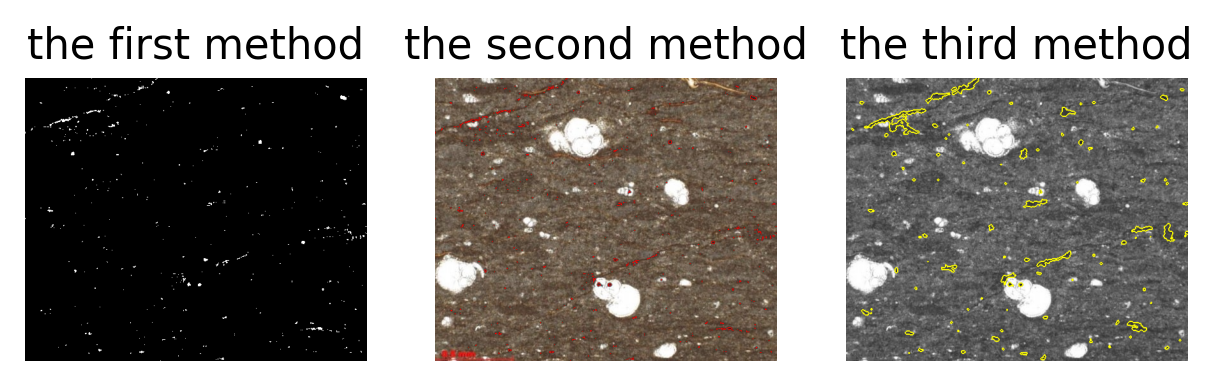

In [24]:
plt.figure(dpi=250)
plt.subplot(1,3,1)         
plt.imshow(mask, cmap = 'gray')
plt.title('the first method')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(img_cnt)
plt.title('the second method')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(mark_boundaries(img_rgb, im_true))
plt.title('the third method')
plt.axis('off')
plt.show()

---

### Estimate quality metrics (number of false positives / false negatives, mean errors for objects counts, etc.).

Because of the fact that we have just one resulting number as an output, it is not possible to use accuracy, for example, as quality metrics, so we decided to use root mean squared error to analyze our results. 

In [25]:
def get_rmse(real_porosity, por_pred):
    real_porosity = [real_porosity]
    rmse = mean_squared_error(real_porosity, por_pred)
    return rmse

#### first method

In [26]:
rmse_1 = get_rmse(real_porosity, porosity_1)

#### second method

In [27]:
rmse_2 = get_rmse(real_porosity, porosity_2)

#### third method

In [28]:
rmse_3 = get_rmse(real_porosity, porosity_3)

### Compare methods (e.g., modifications of your pipeline or your pipeline versus an external baseline).

In [29]:
d = {"rmse":pd.Series([rmse_1, rmse_2, rmse_3], index=['mask', 'contours', 'segmentation'])}
df1 = pd.DataFrame(d)
print('For the', title, 'we have:', '\n', '\n', df1)

For the img2.jpg we have: 
 
                   rmse
mask          1.782258
contours      3.133840
segmentation  0.038179


### Describe the overall CV pipeline suitable to solve the problem.
During our work we figured out that the pipeline with contours detection that was described earlier showed itself as the most suitable for solving the problem. Besides good results, it gave us extra opportunities for image processing and deriving useful information such as pore shapes and porosity types from the sample.



### Provide your motivation for each step of the pipeline.

As for motivation for steps of this pipeline we can mention that:
transferring to hsv color was made for distinguishing pore spaces that become very clear when playing with saturation
the mask for pore spaces was created in order to get more precise contours of pores 
contours were created for calculation of the area of pores
calculating area of contours in the function is an essential part of calculating porosity because porosity is actually the ratio of pore area to the whole sample area in case of microprobes
approximating contours of pores, dividing them into different shapes based on the amount of angles their approximation contours have and getting the most common one gives an understanding of what type of porosity it might be in the reservoir rock


### Provide good examples of the obtained results (don't forget to use a separate test set if you train a supervised algorithm).

This image we consider as a good example of applying pipeline with contours.


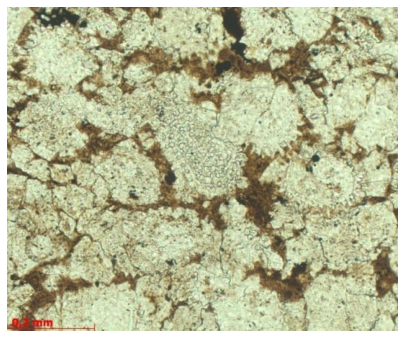

In [32]:
img = cv2.imread('img3.jpg')
title = 'img3.jpg'
orig = img.copy()
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
plot_img(orig, cmap = None)

In [33]:
def all_steps (img, title,porosity):    
    real_porosity = real_poros(title,porosity)

    hsv = img.copy()
    hsv = cv2.cvtColor(hsv, cv2.COLOR_BGR2HSV)
    hue = hsv[:, :, 0]
    light = hsv[:, :, 1]
    sat = hsv[:, :, 2]

    #1
    mask = sat < 70
    mask = mask.astype(np.uint8)

    porosity_1 = por_by_pixels1(mask)

    #2
    mask_int = mask.astype(np.uint8)
    contours, hierarchy = cv2.findContours(mask_int, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    img_cnt = orig.copy()
    cv2.drawContours(img_cnt, contours, -1, (255,0,0), 1)

    allporeareas = []

    for contour in contours:
        area = cv2.contourArea(contour)
        allporeareas.append(area)
    pore_area = np.array(allporeareas).sum()
    pore_area

    porosity_2 = por_by_contours(orig, mask)

    #3
    img_seg = img.copy()
    img_seg = cv2.cvtColor(img_seg, cv2.COLOR_BGR2GRAY)
    img_rgb = cv2.cvtColor(img_seg, cv2.COLOR_BGR2RGB)

    elevation_map = sobel(img_seg)
    markers = np.zeros_like(img_seg)
    markers[img_seg < 31] = 1
    markers[img_seg > 90] = 2
    im_true = watershed(elevation_map, markers)

    porosity_3 = por_by_pixels2(im_true)

    #rmse
    rmse_1 = get_rmse(real_porosity, porosity_1)
    rmse_2 = get_rmse(real_porosity, porosity_2)
    rmse_3 = get_rmse(real_porosity, porosity_3)

    #data frame 
    d = {"rmse":pd.Series([rmse_1, rmse_2, rmse_3], index=['mask', 'contours', 'segmentation'])}
    df3 = pd.DataFrame(d)
    
    plt.figure(dpi=250)
    plt.subplot(1,3,1)         
    plt.imshow(mask, cmap = 'gray')
    plt.title('the first method')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(img_cnt)
    plt.title('the second method')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(mark_boundaries(img_rgb, im_true))
    plt.title('the third method')
    plt.axis('off')
    plt.show()
 
    return print('For the', title, 'we have:', '\n', '\n', df3)

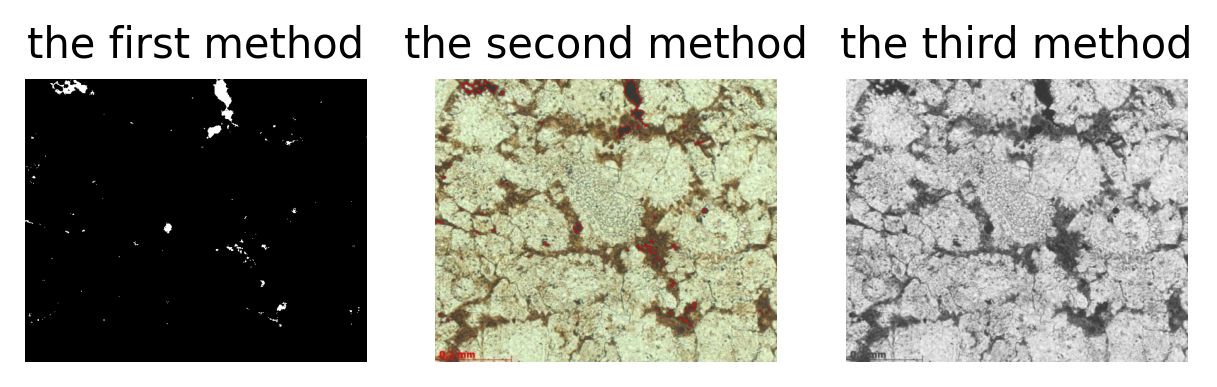

For the img3.jpg we have: 
 
                   rmse
mask          0.511847
contours      0.187712
segmentation  0.168100


In [34]:
all_steps (img, title,porosity)

### Provide bad examples.

This image is definitely a bad example. Why did our algorithm fail? That happened probably because of the layered structure of the rock with different extra shades that could be detected as pore spaces. Also, resolution of this image is not high enough to distinguish micropores correctly.


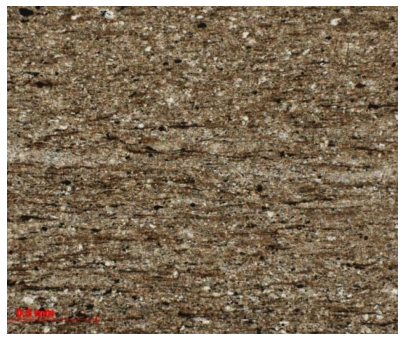

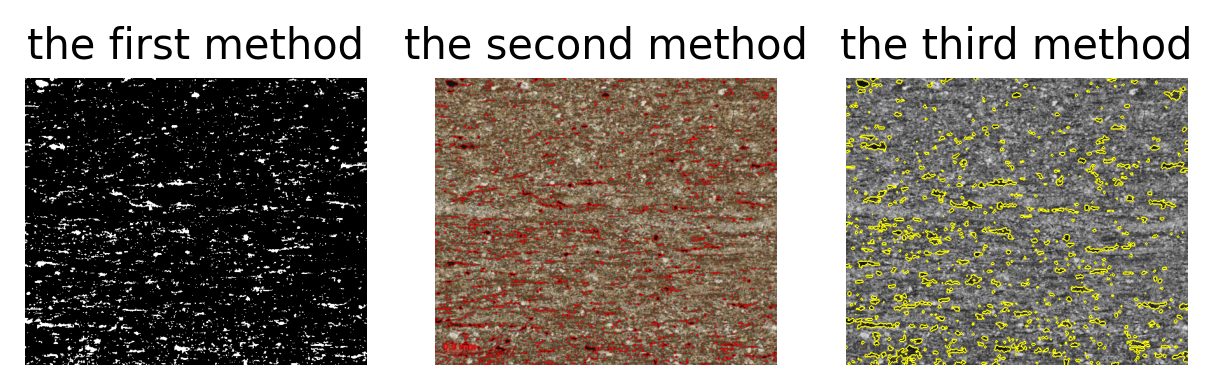

For the img1.jpg we have: 
 
                    rmse
mask           0.150602
contours      13.273196
segmentation   0.019823


In [35]:
img = cv2.imread('img1.jpg')
title = 'img1.jpg'
orig = img.copy()
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
plot_img(orig, cmap = None)

all_steps (img, title,porosity)

### What else we have tried

#### Cnn algorithm for porosity determination   
We really tried to implement convonutional neural network for dolving the task. We have ound different datasets of microprobes (from https://carbonateworld.com and another sources). But we got bad results of our model because of insufficient images of microbes, as well as lack of information on the actual values of porosity, so we could not compare the actual results and conclude whatever this model is good or bad. 

##### We could apply the algorithm if we had more data.

(Below, there is the code for building the model, if you run it, it will show an error, since it refers to several saved images on a personal computer.)

In [36]:
# from tensorflow.python.client import device_lib
# import os

# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder
# from keras.preprocessing import image
# from keras.applications.imagenet_utils import preprocess_input
# import warnings
# warnings.simplefilter("ignore", category=DeprecationWarning)
# from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
# from keras.models import Sequential # to create a cnn model
# from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
# from keras.optimizers import RMSprop,Adam
# from keras.layers.normalization import BatchNormalization
# from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import ReduceLROnPlateau

# PathToFiles = "RockCatalog"
# files = os.listdir(PathToFiles)
# file_count = len(files)
# file_count

# Y_train = np.zeros((file_count,1))

# target_size=(500, 500, 3)
# area = (125, 125, 375, 375)

# sorted(os.listdir(PathToFiles));

# def prepareImages(ydataset ,datasetlength , dataset):
#     X_train = np.zeros((datasetlength, 250, 250, 3))
#     count = 0
#     for name in os.listdir(dataset):
#         img = image.load_img("RockCatalog/" + name, target_size)

#         classification = name[0]
#         img= img.crop(area)
#         x = image.img_to_array(img)
#         x = preprocess_input(x)
#         X_train[count] = x
#         ydataset[count] = classification
#         count += 1
#     return X_train

# def prepare_labels(y):
#     print(y.shape)
#     values=np.array(y)
#     label_encoder=LabelEncoder()
#     integer_encoded=label_encoder.fit_transform(values)
#     onehot_encoder=OneHotEncoder(sparse=False)
#     integer_encoded=integer_encoded.reshape(len(integer_encoded),1)
#     onehot_encoded=onehot_encoder.fit_transform(integer_encoded)
#     y=onehot_encoded
    
#     return y,label_encoder

# X = prepareImages(Y_train, file_count, PathToFiles)
# X /= 255

# col = [1]
# excel = pd.read_excel('./CO3_Thin_Sections.xls', usecols=col)
# excel = excel.values
# excel.shape

# y, label_encoder = prepare_labels(Y_train)

# model = Sequential()
# model.add(Conv2D(filters = 16, kernel_size = (9,9), padding = 'Same', activation = 'relu', input_shape = (250,250,3)))
# model.add(Conv2D(filters = 16, kernel_size = (7,7), padding = 'Same', activation = 'relu'))
# model.add(MaxPool2D(pool_size = (2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation = 'relu'))
# model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
# model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
# model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
# model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))
# model.add(Dropout(0.25))

# # fully connected
# model.add(Flatten())
# model.add(Dense(256, activation = 'relu'))
# model.add(BatchNormalization())
# model.add(Dense(y.shape[1], activation = "softmax"))

# model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
# history = model.fit(X, y, epochs=24, batch_size=100, verbose=1)

#### Preprocessing the image by edges and canny

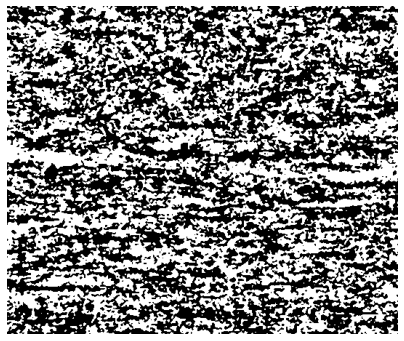

In [37]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
kernel = np.ones((1,1),np.uint8)
morph = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel) 
morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel)
median_gray=cv2.medianBlur(morph,3)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl = clahe.apply(median_gray)
ret,thresh=cv2.threshold(cl,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plot_img(thresh)